<a href="https://colab.research.google.com/github/boldasl/20_IT_PROJECT_009/blob/main/OpAmp_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Dec 14 16:18:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q seaborn # 산포도 확인 라이브러리
!pip install -q livelossplot # 실시간 Loss 확인 라이브러리
#!pip install -q hyperas
print("successfully installed.")

successfully installed.


In [ ]:
import numpy as np
import pandas as pd

# import keras library
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
import seaborn as sns

import random
#from datetime import datetime

print(keras.__version__)

2.4.0


In [ ]:
MAIN_PATH = "./drive/My Drive/Colab Notebooks/20-2_IT_PROJECT/2stage_opamp/"
MODEL_PATH = "model/"
RAW_PATH = "raw_data/"

In [ ]:
# load dataset
raw_dataset = pd.read_csv(MAIN_PATH + RAW_PATH + "opamp_dataset.csv", na_values='?')
dataset = raw_dataset.copy()
raw_dataset

,M1_M2_W,M3_M4_W,M5_W,M6_W,M7_W,M8_W,Ibias,P,Av,BW,SlewRate
0,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,3.20,76.990,173800,0.04267
1,0.000001,0.000001,0.000001,0.000001,0.000001,0.000005,0.000001,1.77,144.900,32640,0.07385
2,0.000001,0.000001,0.000001,0.000001,0.000001,0.000010,0.000001,1.54,186.000,15900,0.08421
3,0.000001,0.000001,0.000001,0.000001,0.000005,0.000001,0.000001,3.20,5.877,630200,0.04103
4,0.000001,0.000001,0.000001,0.000001,0.000005,0.000005,0.000001,1.78,7.260,190800,0.05783
...,...,...,...,...,...,...,...,...,...,...,...
13495,0.000010,0.000010,0.000010,0.000010,0.000005,0.000005,0.000010,43.80,577.400,416300,117.50306
13496,0.000010,0.000010,0.000010,0.000010,0.000005,0.000010,0.000010,30.50,599.300,255000,68.57143
13497,0.000010,0.000010,0.000010,0.000010,0.000010,0.000001,0.000010,141.00,31.610,12600000,0.27350
13498,0.000010,0.000010,0.000010,0.000010,0.000010,0.000005,0.000010,45.00,55.290,3102000,0.31270


In [ ]:
# m -> um scaling
dataset["M1_M2_W"] *= 10 ** 6
dataset["M3_M4_W"] *= 10 ** 6
dataset["M5_W"] *= 10 ** 6
dataset["M6_W"] *= 10 ** 6
dataset["M7_W"] *= 10 ** 6
dataset["M8_W"] *= 10 ** 6

In [ ]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
M1_M2_W,13500.0,5.500000e+00,3.182098e+00,1.000000,3.250000,5.500000e+00,7.750000e+00,1.000000e+01
M3_M4_W,13500.0,5.500000e+00,3.182098e+00,1.000000,3.250000,5.500000e+00,7.750000e+00,1.000000e+01
M5_W,13500.0,5.500000e+00,3.674371e+00,1.000000,1.000000,5.500000e+00,1.000000e+01,1.000000e+01
M6_W,13500.0,5.500000e+00,3.182098e+00,1.000000,3.250000,5.500000e+00,7.750000e+00,1.000000e+01
M7_W,13500.0,5.500000e+00,3.674371e+00,1.000000,1.000000,5.500000e+00,1.000000e+01,1.000000e+01
M8_W,13500.0,5.500000e+00,3.674371e+00,1.000000,1.000000,5.500000e+00,1.000000e+01,1.000000e+01
Ibias,13500.0,5.500000e-06,3.354226e-06,0.000001,0.000003,5.500000e-06,7.750000e-06,1.000000e-05
P,13500.0,2.417960e+01,2.713580e+01,1.410000,7.340000,1.520000e+01,2.850000e+01,1.990000e+02
Av,13500.0,1.122397e+02,1.837978e+02,0.351500,5.835000,1.760000e+01,9.367000e+01,6.675000e+02
BW,13500.0,2.677964e+06,4.190262e+06,5165.000000,301000.000000,1.051500e+06,3.136250e+06,3.600000e+07


In [ ]:
'''
# dataset에서 NaN 값이 있는 행의 개수를 계산하고 삭제.
print(dataset.isna().sum())
dataset = dataset.dropna()
'''

<Figure size 9216x9216 with 0 Axes>

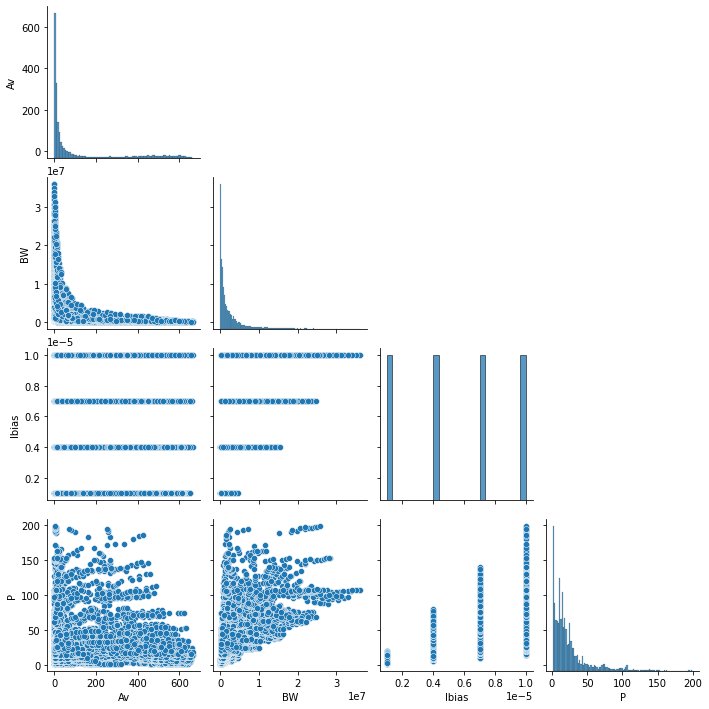

In [ ]:
# check scatter diagram
plt.figure(figsize=(128,128))
g = sns.pairplot(dataset[["Av", "BW", "Ibias", "P"]], diag_kind="auto") # SlewRate를 넣으니까 계속 오류

for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)


In [ ]:
# define normalization functions
def z_score_norm(x, stats):
  return (x - stats['mean']) / stats['std']

def min_max_norm(x, stats):
    return (x - stats['min']) / (stats['max'] - stats['min'])

def simple_norm(x, stats):
    return x / stats['max']

In [ ]:
'''
dataset_without_labels = pd.DataFrame()
dataset_without_labels["Av"] = dataset["Av"]
dataset_without_labels["BW"] = dataset["BW"]
dataset_without_labels["Ibias"] = dataset["Ibias"]
dataset_without_labels["P"] = dataset["P"]
dataset_without_labels["SlewRate"] = dataset["SlewRate"]

dataset_without_labels
'''


In [ ]:
'''
stats = dataset_without_labels.describe()
stats = stats.transpose()
stats
'''

In [ ]:
'''
normed_dataset = z_score_norm(dataset_without_labels, stats)
normed_dataset.describe().transpose()
'''


In [ ]:
'''
normed_dataset["M1_M2_W"] = dataset["M1_M2_W"]
normed_dataset["M3_M4_W"] = dataset["M3_M4_W"]
normed_dataset["M5_W"] = dataset["M5_W"]
normed_dataset["M6_W"] = dataset["M6_W"]
normed_dataset["M7_W"] = dataset["M7_W"]
normed_dataset["M8_W"] = dataset["M8_W"]
normed_dataset
'''


In [ ]:
'''
# removing outliers (1)
normed_dataset_outlier_removed = normed_dataset

normed_dataset_outlier_removed = normed_dataset_outlier_removed[normed_dataset_outlier_removed.Av < 1]
normed_dataset_outlier_removed = normed_dataset_outlier_removed[normed_dataset_outlier_removed.BW < 1]
normed_dataset_outlier_removed = normed_dataset_outlier_removed[normed_dataset_outlier_removed.Ibias < 1]
normed_dataset_outlier_removed = normed_dataset_outlier_removed[normed_dataset_outlier_removed.P < 1]
normed_dataset_outlier_removed = normed_dataset_outlier_removed[normed_dataset_outlier_removed.SlewRate < 1]

normed_dataset_outlier_removed.describe().transpose()
'''


In [ ]:
'''
len(normed_dataset_outlier_removed)
dataset = normed_dataset_outlier_removed
'''


In [ ]:
# removing outliers (2)
dataset = dataset[dataset.Av > 100]

dataset = dataset[dataset.BW > 20000]
dataset = dataset[dataset.BW < 300000]

dataset = dataset[dataset.P < 50]

dataset = dataset[dataset.SlewRate < 50]
dataset = dataset[dataset.SlewRate > 5]
print("# of dataset =", len(dataset))


# of dataset = 535


<Figure size 9216x9216 with 0 Axes>

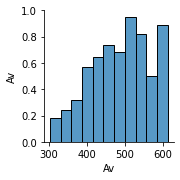

In [ ]:
# Check Scatter Diagram
plt.figure(figsize=(128,128))
g = sns.pairplot(dataset[["Av"]], diag_kind="auto") # SlewRate를 넣으니까 계속 오류

for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)


In [ ]:
# seperate train dataset & test dataset
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print("train_dataset row count =", train_dataset.shape[0])
print("test_dataset row count =", test_dataset.shape[0])


train_dataset row count = 428
test_dataset row count = 107


In [ ]:
# make empty dataframe
train_labels = pd.DataFrame()
test_labels = pd.DataFrame()


In [ ]:
train_labels["M1_M2_W"] = train_dataset.pop("M1_M2_W")
train_labels["M3_M4_W"] = train_dataset.pop("M3_M4_W")
train_labels["M5_W"] = train_dataset.pop("M5_W")
train_labels["M6_W"] = train_dataset.pop("M6_W")
train_labels["M7_W"] = train_dataset.pop("M7_W")
train_labels["M8_W"] = train_dataset.pop("M8_W")

test_labels["M1_M2_W"] = test_dataset.pop("M1_M2_W")
test_labels["M3_M4_W"] = test_dataset.pop("M3_M4_W")
test_labels["M5_W"] = test_dataset.pop("M5_W")
test_labels["M6_W"] = test_dataset.pop("M6_W")
test_labels["M7_W"] = test_dataset.pop("M7_W")
test_labels["M8_W"] = test_dataset.pop("M8_W")


In [ ]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Ibias,428.0,0.000004,0.000003,0.000001,0.000001,0.000004,0.000007,0.00001
P,428.0,13.034463,6.557803,2.940000,8.197500,12.400000,18.225000,31.40000
Av,428.0,471.310280,99.268525,101.700000,415.975000,482.800000,541.775000,612.50000
BW,428.0,152897.383178,69144.641644,31230.000000,107075.000000,145050.000000,199850.000000,299400.00000
SlewRate,428.0,19.151408,11.407691,5.106380,11.951530,14.792020,24.458717,49.74093


In [ ]:
normed_train_dataset = z_score_norm(train_dataset, train_stats)
normed_test_dataset = z_score_norm(test_dataset, train_stats)

normed_train_dataset.describe().transpose()# check normed train dataset stats


,count,mean,std,min,25%,50%,75%,max
Ibias,428.0,-3.964119e-15,1.0,-1.094863,-1.094863,-0.128675,0.837513,1.803701
P,428.0,9.442084e-17,1.0,-1.539305,-0.737589,-0.096749,0.791505,2.800562
Av,428.0,-8.285169e-16,1.0,-3.723338,-0.557430,0.115744,0.709839,1.422301
BW,428.0,-4.176306e-17,1.0,-1.759607,-0.662703,-0.113492,0.679049,2.118785
SlewRate,428.0,-8.767649e-17,1.0,-1.231189,-0.631143,-0.382145,0.465240,2.681482


<Figure size 9216x9216 with 0 Axes>

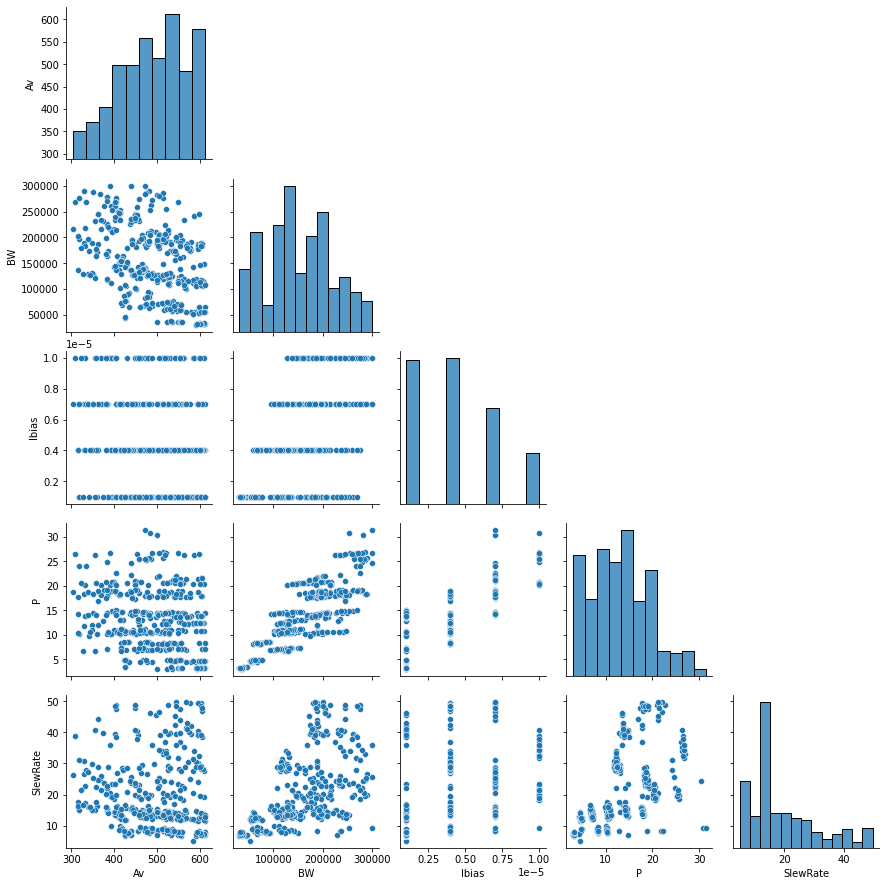

In [ ]:
# check scatter diagram
plt.figure(figsize=(128,128))
g = sns.pairplot(train_dataset[["Av", "BW", "Ibias", "P", "SlewRate"]], diag_kind="auto")

for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)


In [ ]:
def hyperparameter_tuning(learning_rate, network_topology, ridge):
    layers = len(network_topology)

    model = Sequential()
    
    if ridge == False:
        print("normal mse loss")
        model.add(Dense(network_topology[0], activation='relu', input_shape=[len(train_dataset.keys())]))
        model.add(BatchNormalization())
        #model.add(Dropout(0.2))
        for i in range(1, layers):
            model.add(Dense(network_topology[i], activation='relu'))
            model.add(BatchNormalization())
            #model.add(Dropout(0.2))
    else:
        print("l2-regression loss")
        model.add(Dense(network_topology[0], activation='relu', kernel_regularizer=keras.regularizers.l2(LAMBDA), input_shape=[len(train_dataset.keys())]))
        model.add(BatchNormalization())
        for i in range(1, layers):
            model.add(Dense(network_topology[i], activation='relu', kernel_regularizer=keras.regularizers.l2(LAMBDA)))    
            model.add(BatchNormalization())    


    model.add(Dense(len(train_labels.keys())))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=opt, metrics=[])
    return model

In [ ]:
def training(epochs, batch_size):
    history = model.fit(
    normed_train_dataset, train_labels,
    epochs=epochs, 
    verbose = 0,
    batch_size=batch_size, 
    validation_split=0.25,
    callbacks=[livelossplot])
    
    test_loss = model.evaluate(normed_test_dataset, test_labels, batch_size=batch_size)

    final_epochs = len(history.history["loss"])
    print("final epochs =", final_epochs)
    print("test loss =", test_loss)
    
    '''
    time = datetime.now()
    now = "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(time.year, time.month, time.day, time.hour, time.minute, time.second)
    '''

    # save model
    MODEL_FILE_NAME = "TOPOLOGY-{0}_LR-{1}_EPOCHS-{2}_BATCH-{3}_LOSS-{4:0.3f}.model".format(TOPOLOGY, LEARNING_RATE, final_epochs, batch_size, test_loss)
    model.save(MAIN_PATH + MODEL_PATH + MODEL_FILE_NAME)
    print("\n\nmodel successfully saved at", MAIN_PATH + MODEL_PATH + MODEL_FILE_NAME)

    return history, MODEL_FILE_NAME


In [ ]:
# traning configuration
EPOCHS = 2000
BATCH_SIZE = 8
LAMBDA = 0.001
TRIES = 20


In [ ]:
# define callback functions
early_stopping = EarlyStopping(monitor="val_loss", patience=100)
livelossplot = PlotLossesKeras() # 실시간으로 Loss Function 변화를 보여주는 Library
#checkpoint = ModelCheckpoint(MAIN_PATH + MODEL_PATH + MODEL_FILE_NAME, verbose=1, save_best_only=True)

In [ ]:
# random search
layers = [2, 3, 4, 5, 6]
nodes = [32, 64, 128, 256, 512]
lr = [0.0001, 0.001, 0.01]

def random_search():
    topology = []
    depth = layers[random.randrange(len(layers))]
    learning_rate = lr[random.randrange(len(lr))]
    '''
    print("depth =", depth)
    print("learning rate =", learning_rate)
    '''
    for i in range(depth):
        topology.append(nodes[random.randrange(len(nodes))])    

    return topology, learning_rate 


In [ ]:
for n in range(TRIES):
    TOPOLOGY, LEARNING_RATE = random_search()
    print("try =", n+1, "/", TRIES)
    print("topology =", TOPOLOGY)
    print("learning rate =", LEARNING_RATE)
    print()

    model = hyperparameter_tuning(LEARNING_RATE, TOPOLOGY, ridge=False)
    #model.summary()

    hist, file_name = training(EPOCHS, BATCH_SIZE)

    epochs = len(hist.history["loss"])
    train_loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    plt.plot(range(epochs), train_loss, label="Training Loss")
    plt.plot(range(epochs), val_loss, label="Validation Loss")
    plt.legend(loc="upper right")


    file_name = file_name.replace(".model", ".png", 1)

    plt.savefig(MAIN_PATH + "plot/" + file_name)
    plt.clf()
    


In [ ]:
TOPOLOGY = [512, 256, 128, 64]
LEARNING_RATE = 0.001
EPOCHS = 2000
BATCH_SIZE = 8
LAMBDA = 0.01


model = hyperparameter_tuning(LEARNING_RATE, TOPOLOGY, ridge=False)

hist, file_name = training(EPOCHS, BATCH_SIZE)

epochs = len(hist.history["loss"])
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

plt.clf()
plt.plot(range(epochs), train_loss, label="Training Loss")
plt.plot(range(epochs), val_loss, label="Validation Loss")
plt.legend(loc="upper right")


file_name = file_name.replace(".model", ".png", 1)

plt.savefig(MAIN_PATH + "plot/" + file_name)
plt.show()


In [ ]:
print(train_loss[epochs-1])
print(val_loss[epochs-1])

0.10920488089323044
1.9350820779800415


In [ ]:
model = load_model(MAIN_PATH + MODEL_PATH + "TOPOLOGY-512, 256, 128, 64_LR-0.001_EPOCHS-2000_BATCH-8_LOSS-1.393.json")

In [ ]:
test_loss = model.evaluate(normed_test_dataset, test_labels, batch_size=BATCH_SIZE)

14/14 [==============================] - 0s 2ms/step - loss: 1.3932


In [ ]:
example_batch = normed_train_dataset[:10]
example_result = model.predict(example_batch)
print(example_result) # 모델이 예측한 결과값
print(train_labels[:20]) # Ground Truth Value

[[ 9.707091    9.968487    9.938564    5.544913    5.5123115   5.4394655 ]
 [ 0.88321424  3.296363    9.898294    1.0372019   1.0365531   9.841292  ]
 [ 0.9693068  10.333876    5.523387    3.47647     1.0360446  10.092058  ]
 [ 5.496026   10.099033    5.506855    5.5499344   0.99567115  5.4470687 ]
 [ 9.848877   10.063166    5.5288534   5.502608    0.9829496   5.4509754 ]
 [ 3.281416    5.540508    9.987783    1.0539215   1.0285549   9.944738  ]
 [ 3.19273     7.7889466   5.5387707   3.3306482   0.98489577 10.032476  ]
 [ 5.574941    3.0938926   5.467757    1.0299985   0.99949026  9.997865  ]
 [ 7.8755465   3.2111967   5.4346056   0.98360395  1.025853    5.4538836 ]
 [10.051135    7.9127936  10.012475    7.958709    5.497379    1.0094174 ]
 [ 7.7812653   3.2435408   9.97784     5.4928102   5.4858665   9.977661  ]
 [ 5.3902745   7.9372525  10.039024   10.330972    5.6012278   0.9987334 ]
 [ 0.82341534  7.8363857   5.4102263   5.5813656   0.98940027  5.4460573 ]
 [ 0.8142807  10.12598   